In [174]:
#SVM+HOG
import os
from sklearn import model_selection as ms
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib import patches

%matplotlib inline

datadir = "data"
dataset = "pedestrians128x64"
datafile = "%s/%s.tar.gz" % (datadir, dataset)

#入力画像
input_img = "input_img/shuugoumini.jpg"

extractdir = "%s/%s" % (datadir, dataset)

def extract_tar(datafile, extractdir):
    try:
        import tarfile
    except ImportError:
        raise ImportError("You do not have tarfile installed. "
                          "Try unzipping the file outside of Python.")

    tar = tarfile.open(datafile)
    tar.extractall(path=extractdir)
    tar.close()
    print("%s successfully extracted to %s" % (datafile, extractdir))
    
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)



Could not find image data/pedestrians128x64/per00000.ppm
data/pedestrians_neg.tar.gz successfully extracted to data
done
CPU times: user 5.22 s, sys: 175 ms, total: 5.4 s
Wall time: 3.88 s


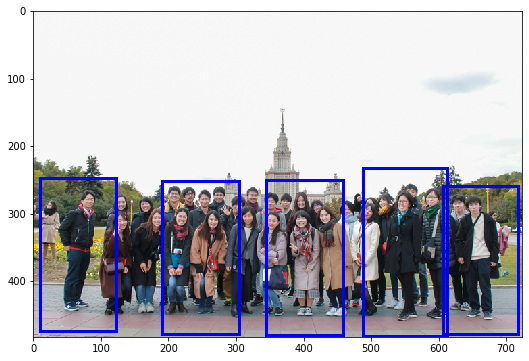

In [175]:
%%time
#SVM+HOGつづき
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)


random.seed(42)
X_pos = []
for i in random.sample(range(900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64))) #ここで画像のhog特徴量を計算している。
    
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)

negset = "pedestrians_neg"
negfile = "%s/%s.tar.gz" % (datadir, negset)
negdir = "%s/%s" % (datadir, negset)
extract_tar(negfile, datadir)


hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64))) #ここで画像のhog特徴量を計算している。
        
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)

X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

svm = train_svm(X_train, y_train)
#score_svm(svm, X_train, y_train)
#score_svm(svm, X_test, y_test)

score_train = []
score_test = []
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('done')
        break
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)
    
img_test = cv2.imread(input_img) #input img name!

stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))
            
##ここからHOGだよーーー
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

hogdef = cv2.HOGDescriptor()

hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

found, _ = hogdef.detectMultiScale(img_test)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='b', linewidth=3, fill=False))
plt.savefig('results_img/detected.png')

In [180]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

def compare_face_recognition(img_name):
    #read image by opencv
    img = cv2.imread(img_name) 
    img_result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #結果出力用

    #opencv haarlike+cascade
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # グレースケール化
    cascade_path =  "./cascades/haarcascade_fullbody_forcomparition.xml"
    cascade = cv2.CascadeClassifier(cascade_path) # detectorを作成
    cascade_locations = cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=1) # 顔認識とパラメーター

    rect_color = (0, 255, 0) #green
    if len(cascade_locations) > 0:
        for x, y, width, height in cascade_locations:
            cv2.rectangle(img_result, (x, y), (x + width, y + height), rect_color, thickness=2)
            
            
            
    #opencv LBP+cascade
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # グレースケール化
    cascade_path =  "./cascades/LBPcascade_fullbody_forcomparition.xml"
    cascade = cv2.CascadeClassifier(cascade_path) # detectorを作成
    cascade_locations = cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=1) # 顔認識とパラメーター

    rect_color = (255, 0, 0) #red
    if len(cascade_locations) > 0:
        for x, y, width, height in cascade_locations:
            cv2.rectangle(img_result, (x, y), (x + width, y + height), rect_color, thickness=2)
            
    
    
#     #opencv HOG+cascade　なんかOpenCV対応してないっぽい
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # グレースケール化
#     cascade_path =  "./cascades/HOGcascade_fullbody_forcomparition.xml"
#     cascade = cv2.HOGDescriptor(cascade_path) # detectorを作成
#     HOGCascade.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
#     cascade_locations = cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=1) # 顔認識とパラメーター

#     rect_color = (255, 0, 255) #purple
#     if len(cascade_locations) > 0:
#         for x, y, width, height in cascade_locations:
#             cv2.rectangle(img_result, (x, y), (x + width, y + height), rect_color, thickness=2)
            

#     #opencv HOG+SVMの描画. 上のセルで解析してる。
#     rect_color = (0, 0, 255) #blue
#     for f in found: #f (ystart, xstart, hroi, wroi)
#         #cv2.rectangle(img_result, (f[0], f[1]), (f[0]+f[2],f[1]+ f[3]), rect_color, thickness=1)
#         cv2.rectangle(img_result, (f[1], f[0]), (f[1]+f[3],f[0]+ f[2]), rect_color, thickness=1)
    return img_result

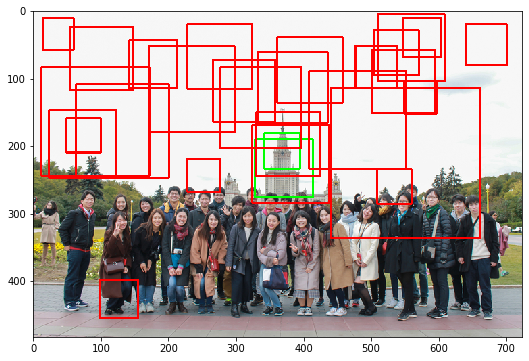

In [181]:
plt.figure(figsize=(10,6))

# ax = plt.subplot(111)
# ax.spines["right"].set_color("none")
# ax.spines["left"].set_color("none")
# ax.spines["top"].set_color("none")
# ax.spines["bottom"].set_color("none")
# ax.tick_params(labelbottom="off",bottom="off")
# ax.tick_params(labelleft="off",left="off")
# ax.text(0.5, 0.7, 'haarcascade', color = "green", fontsize=60, horizontalalignment="center")
# ax.text(0.5, 0.4, 'hog + svm', color = "blue", fontsize=60, horizontalalignment="center")
# ax.text(0.5, 0.1, 'LBPcascade', color = "red", fontsize=60, horizontalalignment="center")

plt.subplot(111)
#plt.title("glasses")
plt.imshow(compare_face_recognition(input_img))

In [185]:
#評価用関数
TP = 21
FP = 25
FN = 45

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F_measure = 2*Precision*Recall/(Precision+Recall)

print("Precision = {}".format(Precision))
print("Recall = {}".format(Recall))
print("F-measure = {}".format(F_measure))

Precision = 0.45652173913043476
Recall = 0.3181818181818182
F-measure = 0.375
